# Importing Packages

In [186]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np 
import seaborn as sns
import sqlite3

def extract_temperature(text_temp):
    if text_temp == ' --- ':
        return None
    return float(text_temp[:text_temp.index('°')-1].strip())

def format_date(date,month,year):
    day = date[:date.index('.')]
    full_date = f"{date[-2:].replace(' ','0')}-{('0'+str(month))[-2:]}-{year}"
    return day,full_date
def extract_sum_cyclist(data):
    s= 0
    d = data["results"][0]["date"] 
    date = d[:d.index('T')]
    for dat in data["results"]:
        s+= dat["sum_counts"]
    return s,date

# Scrapping the Temperature

In [190]:

tmin = []
tmax = []
dates = []
days = []

years = range(2024,2026)
months = range(1,13)
for year in years:
    for month in months:
        # print(f"{month}-{year}")
        url = f"https://www.meteociel.fr/climatologie/obs_villes.php?code2=75107005&mois={month}&annee={year}&sn=0"
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        table  = soup.find("table",style="border-collapse: collapse")
        if table:
            rows = table.find_all("tr")[1:-1]
            for row in rows:
                tmax.append(extract_temperature(row.find("td",bgcolor="#FFDDDD").text))
                tmin.append(extract_temperature(row.find("td",bgcolor="#DDDDFF").text))
                day,date = format_date(row.find("td",bgcolor="#FFFFCC").text,month,year)
                dates.append(date)
                days.append(day) 
df_weather = pd.DataFrame({
                    "date": dates,
                    "day": days,
                    "tmin" : tmin,
                    "tmax": tmax
                  })
df_weather.to_csv("MinMax_temperature_2024_2025")

In [191]:
df_weather

,date,day,tmin,tmax
0,01-01-2024,Lun,4.9,9.6
1,02-01-2024,Mar,7.4,10.7
2,03-01-2024,Mer,8.4,10.3
3,04-01-2024,Jeu,6.2,9.6
4,05-01-2024,Ven,4.4,6.8
...,...,...,...,...
710,19-12-2025,Ven,8.5,10.1
711,20-12-2025,Sam,6.6,9.3
712,21-12-2025,Dim,8.4,11.6
713,22-12-2025,Lun,7.4,10.2


# Getting the Cyclists Counts from API

In [137]:
dates = []
counts = []
years = range(2024,2026)
months = range(1,13)
days = [('0'+str(d))[-2:] for d in range(1,32)]
for year in years:
    for month in months:
        for day in days:
                print(f"{day}-{month}-{year}",end="\r")
                url = "https://opendata.paris.fr" + \
                        "/api/explore/v2.1/catalog/datasets/comptage-velo-donnees-compteurs/" + \
                        f"records?limit=48&refine=name%3A%2236%20quai%20de%20Grenelle%22&refine=date%3A%22{year}%2F{month}%2F{day}%22"
                response = requests.get(url)
                if response.status_code==200:
                        data = response.json()
                        if data["total_count"]>0:                     
                                count,date = extract_sum_cyclist(data)
                                dates.append(date)
                                counts.append(count)                                
df_cyclist = pd.DataFrame({
                    "date": dates,
                    "count": counts
                  })
df_cyclist.to_csv("Cyclists_count")

In [138]:
df_cyclist

,date,count
0,2024-11-01,2359
1,2024-11-02,2703
2,2024-11-03,2592
3,2024-11-04,4996
4,2024-11-05,5380
...,...,...
411,2025-12-17,4817
412,2025-12-18,4968
413,2025-12-19,3649
414,2025-12-20,1921


# Merging the 2 Datasets

## Importing

In [192]:
temperature = pd.read_csv("MinMax_temperature_2024_2025")
cyclist = pd.read_csv("Cyclists_count")

## Formatting

In [193]:
cyclist.date= pd.to_datetime(cyclist.date, format='%Y-%m-%d')
cyclist.index = cyclist.date
cyclist.drop(columns=["Unnamed: 0","date"],inplace=True)
temperature.date= pd.to_datetime(temperature.date, format='%d-%m-%Y')
temperature.index = temperature.date
temperature = temperature[["day","tmin","tmax"]]


In [194]:
df_merged = temperature.merge(cyclist,how="inner",left_on=temperature.index,right_on=cyclist.index)
df_merged.rename(columns={"key_0":"date"},inplace=True)
df_merged.to_csv("project_dataset")

In [195]:
df_merged

,date,day,tmin,tmax,count
0,2024-11-01,Ven,7.1,10.3,2359
1,2024-11-02,Sam,7.6,9.8,2703
2,2024-11-03,Dim,7.1,8.5,2592
3,2024-11-04,Lun,6.6,12.7,4996
4,2024-11-05,Mar,6.4,11.7,5380
...,...,...,...,...,...
411,2025-12-17,Mer,6.9,8.4,4817
412,2025-12-18,Jeu,5.4,13.5,4968
413,2025-12-19,Ven,8.5,10.1,3649
414,2025-12-20,Sam,6.6,9.3,1921


<Axes: xlabel='date', ylabel='count'>

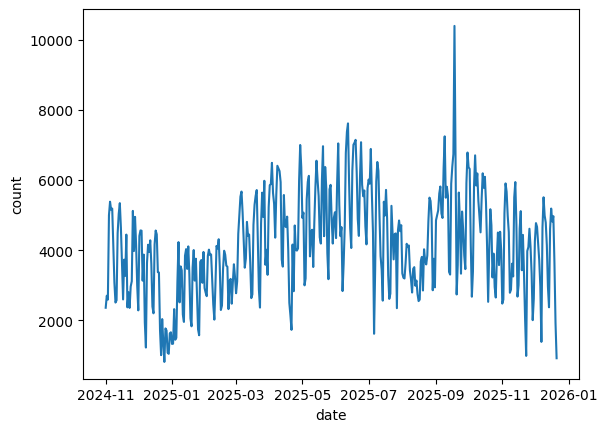

In [196]:
sns.lineplot(data=df_merged,
             x="date",
             y = "count")

## Create SQLite Database from DataFrame

In [199]:
conn = sqlite3.connect('bike_data.db')
df_merged.to_sql('counters',conn, index=False)
conn.close()


In [198]:
conn.close()

### Check the Database

In [203]:
conn = sqlite3.connect('bike_data.db')
print(pd.read_sql_query("SELECT * FROM counters WHERE tmax>15 AND tmin<6 LIMIT 5", conn))
conn.close()

                  date  day  tmin  tmax  count
0  2025-04-02 00:00:00  Mer   5.4  15.5   5880
1  2025-04-18 00:00:00  Ven   5.7  15.8   4000


# SARIMA Model

In [213]:
import numpy as np
import pandas as pd

def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data.
    
    Parameters:
    -------
    data : pd.Series or pd.DataFrame
        Time series data with an index (numeric, datetime, or period).
    split_date : str or numeric
        The date/position on which to split the series.
    
    Returns:
    --------
    (train, test) : tuple of pandas.Series/DataFrame
    '''
    
    idx = data.index

    # Case 1: numeric index
    if np.issubdtype(getattr(idx, "dtype", np.dtype("O")), np.number) or isinstance(idx, pd.Index):
        pos_split = int(split_date)
        pos_split=np.argwhere(idx>pos_split)[0][0]
        train = data.iloc[:pos_split]
        test = data.iloc[pos_split:]

    # Case 2: DatetimeIndex
    elif isinstance(idx, pd.DatetimeIndex):
        split_date = pd.to_datetime(split_date)
        if split_date in idx:
            pos_split = np.argwhere(idx == split_date)[0][0]
        else:
            pos_split = np.argwhere(idx > split_date)[0][0]
        train = data.iloc[:pos_split]
        test = data.iloc[pos_split:]

    # Case 3: PeriodIndex
    elif isinstance(idx, pd.PeriodIndex):
        split_period = pd.Period(split_date)
        if split_period in idx:
            pos_split = np.argwhere(idx == split_period)[0][0]
        else:
            pos_split = np.argwhere(idx > split_period)[0][0]
        train = data.iloc[:pos_split]
        test = data.iloc[pos_split:]

    else:
        raise TypeError(f"Unsupported index type: {type(idx)}")

    return train, test


In [220]:
import numpy as np
import pandas as pd

def ts_train_test_split(data, split_date):
    '''
    Split time series into training and test data.
    
    Parameters:
    -------
    data : pd.Series or pd.DataFrame
        Time series data with an index (numeric, datetime, or period).
    split_date : str or numeric
        The date/position on which to split the series.
    
    Returns:
    --------
    (train, test) : tuple of pandas.Series/DataFrame
    '''
    
    idx = data.index

    # Case 1: numeric index
    if np.issubdtype(getattr(idx, "dtype", np.dtype("O")), np.number):
        try:
            pos_split = int(split_date)  # Try numeric first
        except (ValueError, TypeError):
            raise ValueError("For numeric index, split_date must be a number")
        
        if pos_split >= len(idx):
            raise ValueError(f"split_date {pos_split} exceeds data length {len(idx)}")
            
        train = data.iloc[:pos_split]
        test = data.iloc[pos_split:]

    # Case 2: DatetimeIndex
    elif isinstance(idx, pd.DatetimeIndex):
        split_date = pd.to_datetime(split_date)
        pos_split = np.argwhere(idx > split_date)[0][0]  # First date AFTER split_date
        train = data.iloc[:pos_split]
        test = data.iloc[pos_split:]

    # Case 3: PeriodIndex
    elif isinstance(idx, pd.PeriodIndex):
        split_period = pd.Period(split_date)
        pos_split = np.argwhere(idx > split_period)[0][0]
        train = data.iloc[:pos_split]
        test = data.iloc[pos_split:]

    else:
        raise TypeError(f"Unsupported index type: {type(idx)}")

    return train, test


In [218]:
df_merged = pd.read_csv("project_dataset")
df_merged.index = pd.to_datetime(df_merged.date, format='%Y-%m-%d')
df = df_merged[["count"]]
df.index

DatetimeIndex(['2024-11-01', '2024-11-02', '2024-11-03', '2024-11-04',
               '2024-11-05', '2024-11-06', '2024-11-07', '2024-11-08',
               '2024-11-09', '2024-11-10',
               ...
               '2025-12-12', '2025-12-13', '2025-12-14', '2025-12-15',
               '2025-12-16', '2025-12-17', '2025-12-18', '2025-12-19',
               '2025-12-20', '2025-12-21'],
              dtype='datetime64[ns]', name='date', length=416, freq=None)

In [221]:
train, test = ts_train_test_split(df, '2025-10-01')

# Apply log transformation
train_log = np.log(train).dropna()
test_log = np.log(test).dropna()

In [223]:
# Decompose the data into a trend and seasonal part
from statsmodels.tsa.seasonal import seasonal_decompose
multModel = seasonal_decompose(train_log,model='multiplicative',extrapolate_trend='freq')



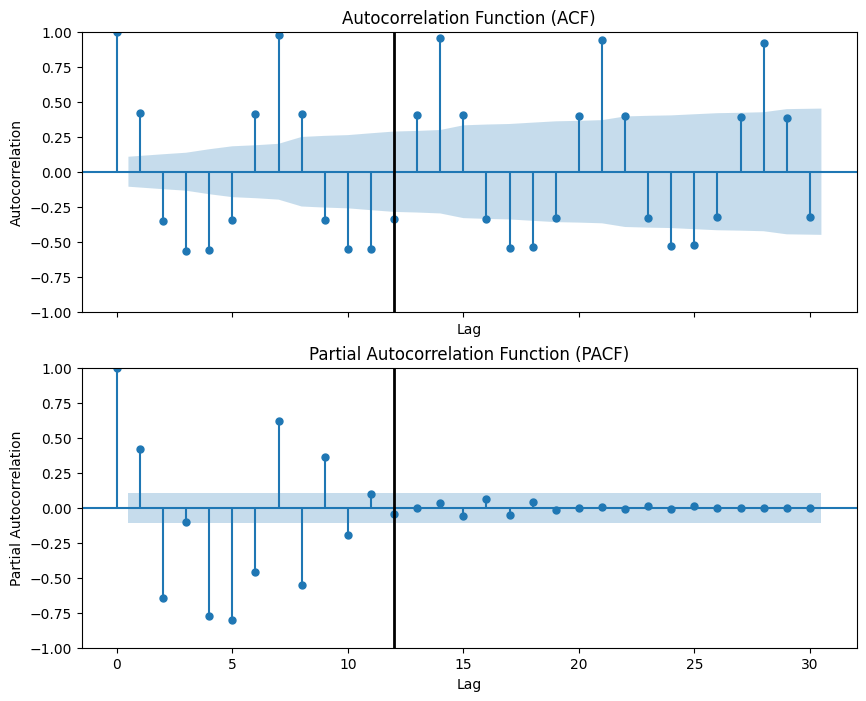

In [225]:
# ACF & PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, sharex=True,figsize=(10, 8))
ax = axes[0]
plot_acf(multModel.seasonal, lags=30, ax=ax) # Plot first 20 lags
ax.plot([12,12],[-1,1],'-k',linewidth=2)
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Function (ACF)")
ax = axes[1]
plot_pacf(multModel.seasonal, lags=30, ax=ax) # Plot first 20 lags
ax.set_xlabel("Lag")
ax.set_ylabel("Partial Autocorrelation")
ax.plot([12,12],[-1,1],'-k',linewidth=2)

ax.set_title("Partial Autocorrelation Function (PACF)")
plt.show() # Display the plotplot_pacf(airline_adj)

In [227]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarm = SARIMAX(
    train['count'],
    order=(1, 1, 1),          # (p, d, q)
    seasonal_order=(1, 1, 1, 7)  # (P, D, Q, s) with s = 7 for weekly seasonality
)
res = sarm.fit()
print(res.summary())


c:\Users\mehdi\anaconda3\envs\extractData\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\mehdi\anaconda3\envs\extractData\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             count   No. Observations:                  335
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2651.356
Date:                           Tue, 23 Dec 2025   AIC                           5312.713
Time:                                   10:53:11   BIC                           5331.663
Sample:                               11-01-2024   HQIC                          5320.274
                                    - 10-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5392      0.069      7.854      0.000       0.405       0.674
ma.L1         -0.8980      0.038    -23.480

c:\Users\mehdi\anaconda3\envs\extractData\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Fit the SARIMA model
from pmdarima import ARIMA

# Your code for the ARIMA model
d  =1 
p = 1
q = 1
# Your code for the ARIMA model
D  =1 
P = 1
Q = 1
s=6
sarm = ARIMA(order=[p,d,q],seasonal_order=[D,P,Q,s])
sarm.fit(train_log)

c:\Users\mehdi\anaconda3\envs\extractData\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\mehdi\anaconda3\envs\extractData\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,order,"[1, 1, ...]"
,seasonal_order,"[1, 1, ...]"
,start_params,None
,method,'lbfgs'
,maxiter,50
,suppress_warnings,False
,out_of_sample_size,0
,scoring,'mse'
,scoring_args,None
,trend,None
,with_intercept,True


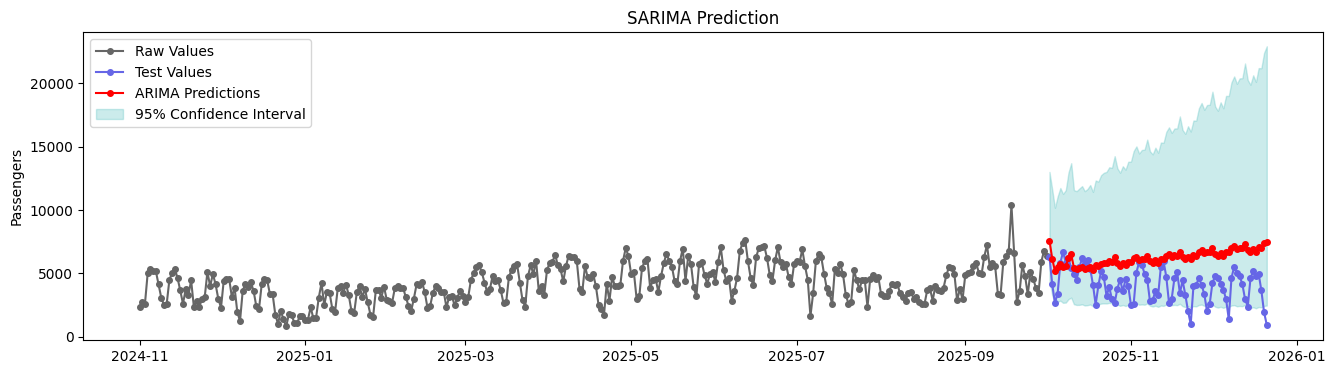

In [234]:
# Show train, test, predictions and confidence interval
from sktime.utils.plotting import plot_series

# Your code showing train, test, predictions and confidence interval

pred_sarm,conf_int = sarm.predict(len(test_log),return_conf_int=True)
fig,ax = plot_series(np.exp(train_log),colors=[(.4,.4,.4)])
plot_series(np.exp(test_log),ax=ax,colors=[(.4,.4,.9)])

plot_series(np.exp(pred_sarm),ax=ax,colors='r')
ax.set_ylabel('Passengers')
ax.set_title('SARIMA Prediction')
conf_int = np.exp(conf_int)
ax.fill_between(test_log.index, conf_int[:,0], conf_int[:,1],alpha=.25,color=[.2,.7,.7])
ax.legend(['Raw Values','Test Values','ARIMA Predictions','95% Confidence Interval'])

plt.show()